In [22]:
# This notebook originally created by L.Stuart

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [1]:
# To install dependencies: pip install metaspace2020>=1.7.2 scikit-learn scikit-image seaborn matplotlib pandas numpy pyimzml
from pathlib import Path
import pandas as pd
import numpy as np
import tifffile as tif
import itertools
from getpass import getpass
import json
from collections import defaultdict
from metaspace.sm_annotation_utils import SMInstance
from sklearn.decomposition import PCA
from skimage.draw import ellipse
import seaborn as sns
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
import matplotlib.pyplot as plt
from matplotlib import rc, rc_context

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':16})
rc('pdf', fonttype=42)
rc('ps', fonttype=42)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [15]:
# Bigger plots
plt.rcParams['figure.figsize'] = 15, 10
# Wider maximum width of pandas columns (needed to see the full lists of molecules)
pd.set_option('max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)

## Utility functions

In [16]:
def make_transform(from_, to, alternating_rows):
    """ 
    Estimate the coordinate-space transform to map coordinates in `from_` to the values in `to`.
    Returns a function to convert from `from_`-space to `to`-space
    """
    from_padded = []
    for row, col in from_:
        if alternating_rows and row % 2 == 1:
            from_padded.append((row, col + 0.5, 1))
        else:
            from_padded.append((row, col, 1))

    to_padded = [(*c, 1) for c in to]
    res = np.linalg.lstsq(from_padded, to_padded, rcond=None)
    mat = res[0]

    def transform(*x):
        if len(x) == 1 and isinstance(x[0], tuple):
            x = x[0]
        return np.dot([*x, 1], mat)[:-1]

    return transform


def make_mask(h, w, positions, grid_coords, n_rows, n_cols, spot_h, spot_w, alternating_rows):
    """
    Calculates a mask where each pixel value indicates which spot it's in, with `0` meaning 'background'.
    Returns the 2d mask, and a list mapping values to spot names (e.g. '0_1' for row 0 column 1).
    """
    cell_to_position = make_transform(grid_coords, positions, alternating_rows)
    rx, ry = spot_h / 2, spot_w / 2
    mask = np.zeros((h, w), np.int32)
    mask_names = ['background']
    
    i = 1
    for y in range(n_rows):
        odd = alternating_rows and y % 2 == 1
        xs = range(n_cols)
        for x in xs:
            yc, xc = cell_to_position(y, x + 0.5 if odd else x)
            # Snap the calculated coordinates to the pixel grid so that generated ellipses have the same shape
            yc = round(yc) + 0.5 - ry % 1
            xc = round(xc) + 0.5 - rx % 1
            xx, yy = ellipse(yc, xc, ry, rx, (h, w))
            mask[xx, yy] = i
            mask_names.append(f'{y}_{x}')
            i += 1
    return mask, mask_names


def colorize_mask(mask):
    """
    Converts each mask value to a color, with background values being fully transparent. 
    For visualization only.
    """
    cnt = np.max(mask)
    print(cnt)
    palette = [
        (0,0,0,0),
        *[(r,g,b,0.5) for r,g,b in sns.color_palette('hls', int(cnt))]
    ]
    image = np.empty((*mask.shape, 4))
    print(image.shape)
    for (y, x), val in np.ndenumerate(mask):
        image[y, x, :] = palette[val]
    return image

# Log in to METASPACE

**Hidden feature:** If you make a file containing your API key, `SMInstance` will automatically log in and you won't need to enter your API key every time.

You can create this file with:

```python
from pathlib import Path
(Path.home() / '.metaspace').open('w').write('api_key=XXXXXX' + '\n')
```

*(replace the XXXXXX with you actual API key)*

In [17]:
# sm = SMInstance()
sm = SMInstance(host='https://metaspace2020.eu') 
if not sm.logged_in():
    print('Enter your API key from https://metaspace2020.eu/user/me')
    sm.login(api_key=getpass())
else:
    print('Already logged in')

Already logged in


# Select a dataset and download data

**Select a dataset and database/fdr for the images to use for alignment in the below cell**

In [114]:
dataset_id = '2021-06-18_10h37m54s'
dataset_nickname = '9AA_neg_mz70-1510'
fdr = 0.5
database = ('Spotting_project_compounds-v9', 'feb2021')

project_root = Path.cwd().parents[0]
p_analysis = project_root / r"matrix_comparison/2_grid_calibration"

# Define input/output paths
input_grid_file = p_analysis / 'input_grids' / f'{dataset_nickname}_{dataset_id}.json'
output_mask_file = p_analysis / 'grid_masks' / f'{dataset_nickname}_{dataset_id}.npy'
output_mask_names_file = p_analysis / 'grid_masks' / f'{dataset_nickname}_{dataset_id}_mask_names.json'

In [115]:
# Download annotations & images
ds = sm.dataset(id=dataset_id)
images = ds.all_annotation_images(fdr, database, True, True)#, offSample=False

# Put images into a dictionary for easy lookup
images = dict(((img.formula, img.adduct, img.neutral_loss), img[0]) for img in images)

# In the newer versions of metaspace some ions have no image (due to no signal?) but are still returned by all_annotaion_images, drop them
images = {key: value for key, value in images.items() if value is not None}

# Get width & height
h, w = next(iter(images.values())).shape

# Create a 2D numpy array where each row is a linearized 1D image, 
# for easy simultaneous manipulation of all images
images_flat = np.array(list(images.values())).reshape(len(images), -1)

100%|████████████████████████████████████████| 4176/4176 [00:32<00:00, 126.67it/s]                                     


In [116]:
guide_spot_formulas = ['C8H10N4O2', 'C28H31N2O3'] # caffeine, rhodamine
adducts = ds.adducts
# neutral_losses = ds.config['isotope_generation'].get('neutral_losses', [''])
neutral_losses = [""]

guide_images = []
for i in list(itertools.product(guide_spot_formulas, adducts, neutral_losses)):
    if i in images.keys():
        guide_images.append(images[i])

# Find a good image to help with alignment

<IPython.core.display.Javascript object>


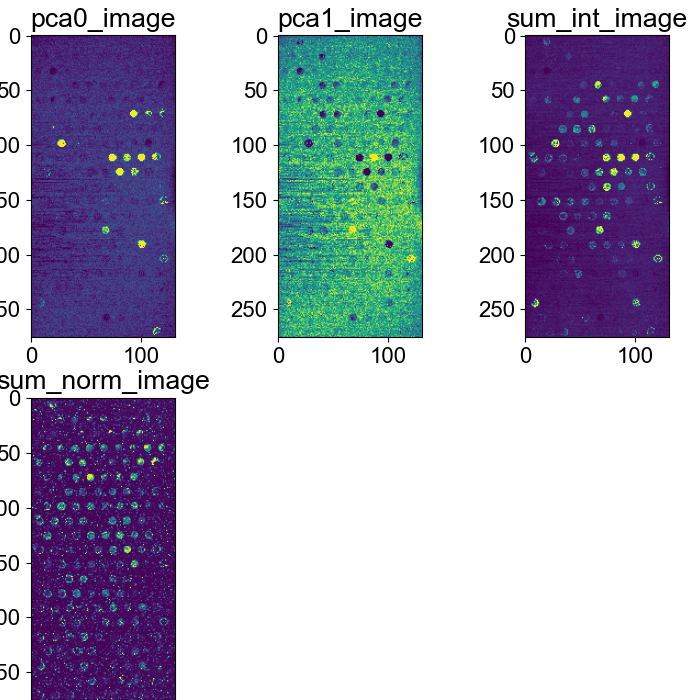

In [117]:
# Individual ion images usually aren't great for alignment.
# This just calculates 4-5 types of summary images - usually one or two will
# clearly show a wide selection of spots, which helps a lot
pca = PCA(10, whiten=True)
pca.fit(images_flat)

def prep_image(flat_image):
    img = np.clip(flat_image, np.percentile(flat_image, 1), np.percentile(flat_image, 99)).reshape(h, w)
    img -= np.min(img)
    return img

pca0_image = prep_image(pca.components_[0])
pca1_image = prep_image(pca.components_[1])
sum_int_image = prep_image(np.sum(images_flat, axis=0))
sum_norm_image = prep_image(np.sum(images_flat / np.sum(images_flat, axis=1, keepdims=True), axis=0))
sum_guide_image = np.log(sum(guide_images)+1)

plt.close('all')
plt.figure(figsize=(7,7))
plt.subplot(2,3,1, title='pca0_image')
plt.imshow(pca0_image)
plt.subplot(2,3,2, title='pca1_image')
plt.imshow(pca1_image)
plt.subplot(2,3,3, title='sum_int_image')
plt.imshow(sum_int_image)
plt.subplot(2,3,4, title='sum_norm_image')
plt.imshow(sum_norm_image)
if sum_guide_image.sum() != 0:
    plt.subplot(2,3,5, title='log_sum_guide_image')
    plt.imshow(sum_guide_image)
plt.autoscale(tight=True)
plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0)
plt.show()

**Uncomment the line for one of the above guide images to be used for alignment**

In [118]:
example_image = pca0_image
# example_image = pca1_image
# example_image = sum_int_image
# example_image = sum_norm_image
# example_image = sum_guide_image # this is am inage of rhodamine and caffeine summed (if ions appear in dataset)

# Create grid calibration file (if it doesn't already exist)

In [119]:
# This writes a template JSON file as a starting point for alignment
# The "help:" fields aren't actually used, it's just an easy way to leave inline comments in JSON
# If the file already exists, this doesn't do anything
if not input_grid_file.exists():
    input_grid_file.parent.mkdir(parents=True, exist_ok=True)
    n_rows, n_cols = 7, 5
    input_grid_file.open('w').write(f"""
{{
    "help:general": "Keep in mind that json is a different format and much less forgiving than Python. Don't add a comma after the last item in a list, and keep true/false lower-case",
    "help:positions": "Pixel coordinates of the centers of calibration spots [y, x]",
    "positions": [[0, 0], [0, {w}], [{h}, 0], [{h}, {w}]],
    "help:grid_coords": "Grid coordinates of the calibration spots. Same spot order as positions. [row, col]",
    "grid_coords": [[0, 0], [0, {n_cols-1}], [{n_rows-1}, 0], [{n_rows-1}, {n_cols-1}]],
    "help:n_rows_n_cols": "Size of the grid",
    "n_rows": 21,
    "n_cols": 9,
    "help:spot_h_spot_w": "Height / width of each spot",
    "spot_h": 15,
    "spot_w": 15,
    "help:image_h_image_w": "Image dimensions (should not be adjusted)",
    "image_h": {h},
    "image_w": {w},
    "help:alternating_rows": "'true' if every odd-numbered row is shifted, 'false' for a rectangular grid",
    "alternating_rows": true
}}
    """)
    print(f"Created {input_grid_file.resolve()}")
else:
    print(f"Grid calibration file already exists at {input_grid_file.resolve()}")
print("Now open this file in another editor and adjust the parameters while re-running the below cell to calibrate the grid")

Grid calibration file already exists at D:\saharuka\spotting\project_git\data\matrix_comparison\2_grid_calibration\input_grids\9AA_neg_mz70-1510_2021-06-18_10h37m54s.json
Now open this file in another editor and adjust the parameters while re-running the below cell to calibrate the grid


# Test grid calibration file

### Guide dot row is row 0, the leftmost column in every row is column 0 

In [120]:
class Cursor:
    """
    A cross hair cursor.
    """
    def __init__(self, ax):
        self.ax = ax
        self.horizontal_line = ax.axhline(color='w', lw=0.8, ls='--')
        self.vertical_line = ax.axvline(color='w', lw=0.8, ls='--')
        # text location in axes coordinates
        self.text = ax.text(0.72, 0.9, '', transform=ax.transAxes, color='r')

    def set_cross_hair_visible(self, visible):
        need_redraw = self.horizontal_line.get_visible() != visible
        self.horizontal_line.set_visible(visible)
        self.vertical_line.set_visible(visible)
        self.text.set_visible(visible)
        return need_redraw

    def on_mouse_move(self, event):
        if not event.inaxes:
            need_redraw = self.set_cross_hair_visible(False)
            if need_redraw:
                self.ax.figure.canvas.draw()
        else:
            self.set_cross_hair_visible(True)
            x, y = event.xdata, event.ydata
            # update the line positions
            self.horizontal_line.set_ydata(y)
            self.vertical_line.set_xdata(x)
            self.text.set_text('x=%1.2f, y=%1.2f' % (x, y))
            self.ax.figure.canvas.draw()

<IPython.core.display.Javascript object>


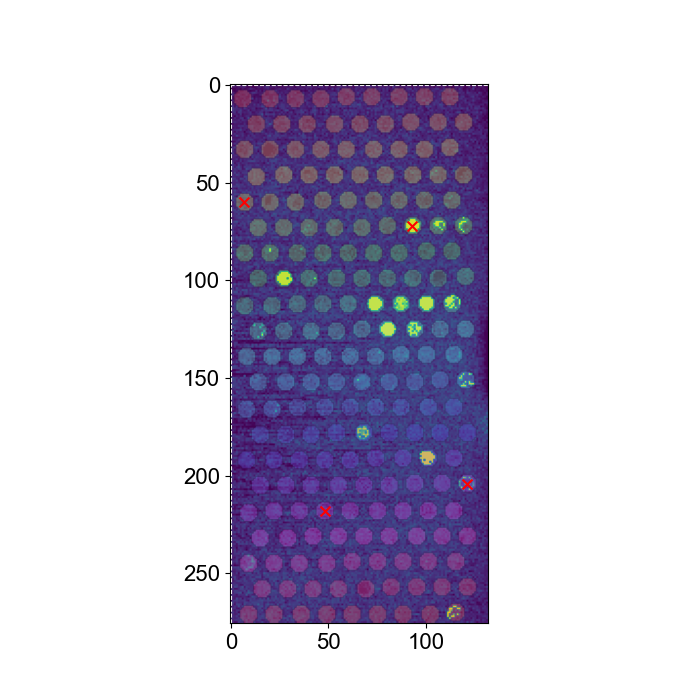

189
(276, 132, 4)


In [121]:
# Load the calibration file
input_grid = json.load(input_grid_file.open('r'))
# Convert it to a mask
grid_mask, mask_names = make_mask(
    h, w,
    input_grid['positions'], 
    input_grid['grid_coords'], 
    input_grid['n_rows'], 
    input_grid['n_cols'], 
    input_grid['spot_h'], 
    input_grid['spot_w'],
    input_grid['alternating_rows'],
)
# Display the mask over the top of the guide image
plt.close('all')
plt.figure(figsize=(7,7))
plt.imshow(example_image)
plt.imshow(colorize_mask(grid_mask), interpolation='bilinear', alpha=0.7)
ys, xs = zip(*input_grid['positions'])
plt.scatter(xs, ys, marker='x', c='red', s=50)
cursor = Cursor(plt.gca())
plt.gcf().canvas.mpl_connect('button_press_event', cursor.on_mouse_move)
plt.show()

In [206]:
# plt.savefig(project_root / r'matrix_comparison/6_figures/figure_1' / 'grid_fitting_panel.pdf') # made using "norharmane_rep_pos_2021-10-20_16h40m03s.json"

# When finished calibrating, save the mask for use in analysis steps

In [ ]:
output_mask_file.parent.mkdir(parents=True, exist_ok=True)
np.save(output_mask_file, grid_mask)
output_mask_names_file.parent.mkdir(parents=True, exist_ok=True)
json.dump(mask_names, output_mask_names_file.open('w'))